In [1]:
%run _init_notebook.ipynb
import matplotlib.gridspec as gridspec
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from approxmh.vae import ConvVAE
from approxmh.model_trainers import AdaptiveVAETrainer, AdaptiveFlowTrainer
from approxmh.distributions import create_serpentine, create_random_gaussian_mixture, IndependentMultivariateNormal, Funnel, PoorlyConditionedGaussian
from approxmh.samplers import AdaptiveVAESampler, MetropolisHastingsFilter, VAEGlobalMHFilter, VAEMetropolisWithinGibbsSampler
from approxmh.utilities import visualize_distribution
from approxmh.likelihood_estimators import SISLikelihoodEstimator, IWLikelihoodEstimator
from approxmh.y_utils import *
from approxmh.distribution_metrics import CoordinateDistributionMetric, TotalVariation1d
from approxmh.rnvp import RNVP
from approxmh.pyro_samplers import NUTS
from approxmh.utilities import count_parameters, dataloader_from_tensor

device: cpu


2024-10-31 21:03:56.907220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 21:03:56.917391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 21:03:56.920339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 21:03:57.869889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([5, 1, 28, 28])
Shape of images batch: torch.Size([64, 1, 28, 28])


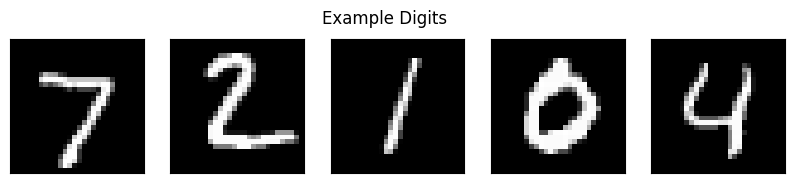

In [16]:
# Define the transformation for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5 and std 0.5
])


class MNISTWithoutLabels(datasets.MNIST):
    def __getitem__(self, index):
        image, _ = super().__getitem__(index)  # Discard label
        return image  # Only return the image


train_dataset = MNISTWithoutLabels(root='./data', train=True, download=True, transform=transform)
val_dataset = MNISTWithoutLabels(root='./data', train=False, download=True, transform=transform)

# Images to show and to test reconstruction quality
n_display_imgs = 5
display_imgs = torch.stack([val_dataset[i] for i in range(n_display_imgs)])
print(display_imgs.shape)

fig, axs = plt.subplots(ncols=5, figsize=(10, 2))
fig.suptitle('Example Digits')
for ax, img in zip(axs, display_imgs):
    ax.imshow(img[0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Create dataloaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

# Check the shape of the data
data_iter = iter(train_loader)
images = next(data_iter)
print(f"Shape of images batch: {images.shape}")  # e.g., torch.Size([64, 1, 28, 28])

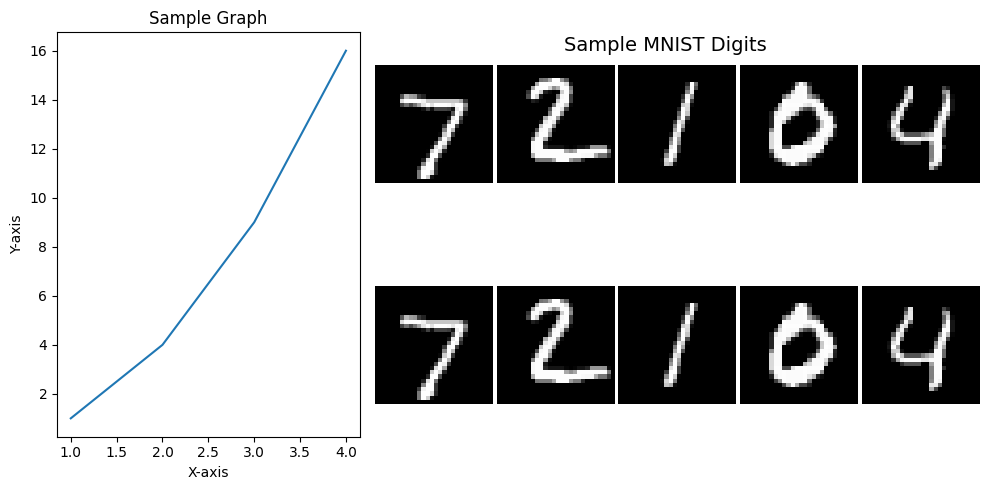

In [18]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Define a GridSpec layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Left side: plot a graph
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Sample Graph")
ax1.plot([1, 2, 3, 4], [1, 4, 9, 16])
ax1.set_xlabel("X-axis")
ax1.set_ylabel("Y-axis")

# Right side: 2x5 grid of MNIST digits
gs_right = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs[0, 1])
fig.text(0.67, 0.9, "Sample MNIST Digits", fontsize=14, ha="center", va="center")

for i in range(2):
    for j in range(5):
        ax = fig.add_subplot(gs_right[i, j])
        ax.imshow(display_imgs[j][0], cmap='gray')
        ax.axis('off')  # Hide axes for cleaner display

plt.tight_layout()

In [30]:
vae = ConvVAE(
    data_dim=images.shape[2],
    latent_dim=16,
    device=device
)

vae_trainer = AdaptiveVAETrainer(
    target=None,
    model=vae,
    model_log_likelihood=None,
    optimizer='adam',
    lr=1e-3,
    kl_annealing_epochs=5,
    no_kl_penalty_epochs=0,
    warmup_epochs=5,
#    scheduler="steplr",
#    scheduler_step_size=150,
#    scheduler_gamma=0.1,
)

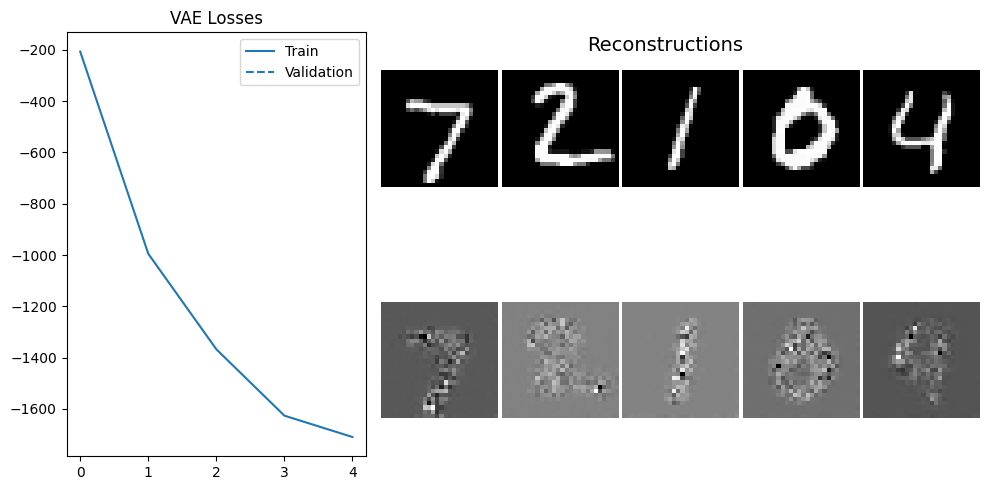

In [31]:
# %%time
def visualize_training(n_epochs=300):
    plot_interval = 1
    metric = CoordinateDistributionMetric(TotalVariation1d(), projection_coordinates=(0,1))
    models = [
        ('VAE', vae, vae_trainer, 'tab:blue'),
#        ('Flow', flow, flow_trainer, 'tab:orange')
    ]
    n_models = len(models)
    for _, _, trainer, _ in models:
        trainer.clear_loss_history()
    
    test_logs = defaultdict(list)

    def plot_statistic(self, model_id, statistic_name, *args, **kwargs):
        model_name, _, _, color = models[model_id]
        statistic = test_logs[model_name + '_' + statistic_name]
        return self.plot(np.arange(1, len(statistic)+1), statistic, c=color, *args, **kwargs)
    mpl.axes.Axes.plot_statistic = plot_statistic
        
    
    vae.train()
    # flow.train()
    
    for epoch_idx in range(1, n_epochs + 1):
        for model_name, model, trainer, color in models:
            trainer.run_classic_epoch(train_loader, val_loader)

        if epoch_idx == 1 or epoch_idx % plot_interval == 0:
            clear_output(wait=True)
            fig = plt.figure(figsize=(10, 5))
            gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
            
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.set_title(f'{models[0][0]} Losses')
            ax1.plot(*models[0][2].get_loss_history(train=True), label='Train', color=models[0][3])
            ax1.plot(*models[0][2].get_loss_history(train=False), label='Validation', linestyle='--', color=models[0][3])
            ax1.legend()
            
            gs_right = gridspec.GridSpecFromSubplotSpec(2, n_display_imgs, subplot_spec=gs[0, 1])
            fig.text(0.67, 0.9, "Reconstructions", fontsize=14, ha="center", va="center")
            vae.eval()
            with torch.no_grad():
                display_img_reconstructions = vae.reconstruct(display_imgs)
            imgs_to_plot = torch.stack((display_imgs, display_img_reconstructions))
            vae.train()
            for i in range(2):
                for j in range(n_display_imgs):
                    ax = fig.add_subplot(gs_right[i, j])
                    ax.imshow(imgs_to_plot[i][j][0], cmap='gray')
                    ax.axis('off')
            
            plt.tight_layout()         
            plt.show()
    
    vae.eval()
    # flow.eval()

visualize_training(n_epochs=5)